## Visualizing Convolutional Layer Saliency Maps

This notebook demonstrates a technique recently published by NVIDIA that gives insight into what portions of input images the DQN agent focuses on when predicting Q-values. It's a simple and efficient algorithm that can be used during both training & testing to debug how the conv layers process input.   

The basic algorithm implemented below:
* Run the trained DQN agent for some number of games to collect sample states.
* Extract the activation outputs of each conv layer using a Keras Model and run the states through to collect activations for each sample.
* For each sample:
  * Average the activation feature maps at each layer, e.g. 7x7x64 --> 7x7
  * For each layer (starting at the last conv layer right before the FC hidden):
    * Resize/upsample the averaged activation map to the size of the preceding layer activation map.
    * Element-wise multiply map with preceding layer activation. For the next iteration, this becomes the input activation for the upsample step.
  * After multiplying by conv layer 1's activations, upsample to original image size. This is now the saliency mask.
  * Stack mask 3x to match # of channels in state image.
  * Blend the mask and state image.


An illustration of this process will probably help:

![](https://github.com/leonardoaraujosantos/DLMatFramework/raw/7000a47c71f07462b14ef09736a577e4dbdea2e3/virtual/tensorDriver/notebooks/NvidiaSalient.png)

# Implementation

In [1]:
from __future__ import print_function, division
import os
import glob
import subprocess
import gym
import random
import numpy as np
from dqn import Agent, Util
import tensorflow as tf
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Load the pre-trained Breakout agent

In [2]:
# Create our gym environment
env = gym.make('Breakout-v0')
# And pass it to the Agent to initialize the pretrained network
agent = Agent(env, mode='test', load_network=True, epsilon=0.01)

[2017-05-31 17:45:46,858] Making new env: Breakout-v0


Environment <TimeLimit<AtariEnv<Breakout-v0>>> has 4 actions
INFO:tensorflow:Restoring parameters from saved_networks/Breakout-v0-44400000


[2017-05-31 17:45:47,411] Restoring parameters from saved_networks/Breakout-v0-44400000


Successfully loaded: saved_networks/Breakout-v0-44400000


## Play a couple of episodes and store the states

In [3]:
NUM_EPISODES = 1
NO_OP_STEPS  = 30       # Max # of steps to do nothing, helps randomize init condition
STATE_LENGTH = 4        # # of previous frames to stack as our "state"

obvs = []               # Store observation RGB frames
states = []             # Store 84x84x4

# Play NUM_EPISODES games
for _ in range(NUM_EPISODES):   
    total_reward = 0
    terminal = False
    
    # Initialize environment
    observation = env.reset()
    # For a random # of steps do nothing, helps to randomize init state
    for _ in range(random.randint(1, NO_OP_STEPS)):
        observation, _, _, _ = env.step(0)  # Do nothing

    # Preprocess 210x160x3 RGB observation to 84x84x1 
    state = Util.preprocess(observation)
    # Create initial state by repeating the first frame 4x to create 84x84x4 input
    state = np.stack([state]*STATE_LENGTH, axis=2).reshape((84,84,4))

    while not terminal:   
        obvs.append(observation)
        states.append(state)
        
        # Feed the state into the model to get an action (determined by max Q-value)
        action = agent.get_action(state)
        
        # Take the action and get new observation, reward, and if we are done with the episode
        observation, reward, terminal, _ = env.step(action)
        
        total_reward += reward
        
        # Convert new observation to 84x84x1
        next_state = Util.preprocess(observation)
        # Pop the oldest frame and append the processed new frame
        next_state = np.append(state, next_state, axis=2)[:,:,1:]

        # next_state will become the state input for the next timestep
        state = next_state
    print ("Reward",total_reward)
print ("Collected {} frames".format(len(states)))

Reward 274.0
Collected 3246 frames


## Summary of the DQN architecture:

In [4]:
agent.q_network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1606144   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 1,686,180
Trainable params: 1,686,180
Non-trainable params: 0
_________________________________________________________________


## Predict Q-values for each state

In [5]:
qs = agent.q_values.eval(feed_dict={agent.s:(np.array(states))})
qs

array([[ 1.69621611,  1.7022382 ,  1.66535759,  1.68988323],
       [ 1.70208204,  1.69295716,  1.68086863,  1.69887567],
       [ 1.71387208,  1.70240974,  1.69862604,  1.71206355],
       ..., 
       [ 2.97790456,  3.01646066,  3.18296599,  3.06212544],
       [ 2.9593873 ,  2.99329185,  3.1594038 ,  3.05213928],
       [ 2.98508906,  3.02052188,  3.17819357,  3.07732654]], dtype=float32)

## Build Keras Model to output intermediate conv layer activations

See: https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

In [6]:
from keras.models import Model

input_tensor = agent.q_network.layers[0].input
conv3_out = agent.q_network.get_layer('conv2d_3').output
conv2_out = agent.q_network.get_layer('conv2d_2').output
conv1_out = agent.q_network.get_layer('conv2d_1').output

intermediate_activation_model = Model(inputs=input_tensor,
                                      outputs=[conv3_out, conv2_out, conv1_out])

In [7]:
intermediate_activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
Total params: 77,984
Trainable params: 77,984
Non-trainable params: 0
_________________________________________________________________


## Grab activations for each conv layer for the samples

In [8]:
sample_states = np.array(states)
conv3act, conv2act, conv1act = intermediate_activation_model.predict(sample_states)

print(conv3act.shape)
print(conv2act.shape)
print(conv1act.shape)

(3246, 7, 7, 64)
(3246, 9, 9, 64)
(3246, 20, 20, 32)


## Average activations

In [9]:
avgc3 = np.mean(conv3act,axis=3)
avgc2 = np.mean(conv2act,axis=3)
avgc1 = np.mean(conv1act,axis=3)

print(avgc3.shape)
print(avgc2.shape)
print(avgc1.shape)

(3246, 7, 7)
(3246, 9, 9)
(3246, 20, 20)


## Upscale and element-wise multiply on all layers

In [10]:
blends = []
salients = []
for state, a3, a2, a1 in zip(sample_states, avgc3, avgc2, avgc1):
    avgC3up = scipy.misc.imresize(a3, [a2.shape[0], a2.shape[1]])
    multC23 = np.multiply(avgC3up, a2)
    multC23up = scipy.misc.imresize(multC23, [a1.shape[0], a1.shape[1]])
    multC12 = np.multiply(multC23up, a1)
    multC12up = scipy.misc.imresize(multC12, [84, 84])  # Upscale mask to image size
    
    # Normalize
    salient_mask = (multC12up - np.min(multC12up))/(np.max(multC12up) - np.min(multC12up))

    # Repeat mask to get 84x84x3 and scale to 0-255
    salient_mask_stacked = np.stack([salient_mask]*3, axis=-1) * 255
    
    salients.append(salient_mask_stacked)

    # Mix parts of state img and mask and round to ints
    blendImg = np.round((0.4*(state[:,:,1:]*255)) + (0.6*salient_mask_stacked))
    blends.append(blendImg)
    
len(blends)

3246

## Let's take a look at a state, its saliency mask, and the two combined

In [11]:
# Choose a random state
state_idx = random.randint(0,len(salients))

(84, 84, 4)

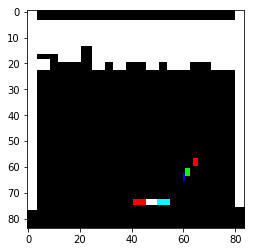

In [12]:
plt.imshow((sample_states[...,1:]*255)[state_idx])
state.shape

(84, 84, 3)

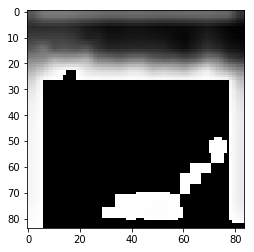

In [13]:
plt.imshow(np.round(salients[state_idx]))
salients[state_idx].shape

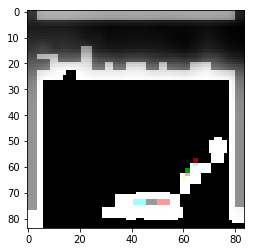

In [14]:
plt.imshow(blends[state_idx])

## Stack the state frames and saliency map side-by-side

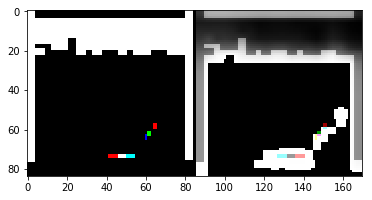

In [15]:
states_salients = np.concatenate([sample_states[..., 1:], 
                                  np.zeros((sample_states.shape[0],sample_states.shape[1],2,3)), 
                                  np.array(blends)], 
                                  axis=2)
states_salients.shape
plt.imshow(states_salients[state_idx])

## Generate a video

**NOTE:** This will not overwrite an existing video.

In [16]:
def generate_video(image_list, folder, video_name):
    curr_folder = os.getcwd()

    if not os.path.exists(folder):
        os.mkdir(folder)
    
    idx_img = 0
    for img in image_list:     
        img_path = folder + '/salient_' + str(idx_img) + '.png'
        plt.imsave(img_path, img)  
        idx_img += 1

    subprocess.call([
        'ffmpeg', '-i', folder + '/salient_%d.png', 
        '-r', '60', 
        '-vf', 'fps=60',
        '-pix_fmt', 'yuv420p',
        '-c:v', 'libx264',
#         '-preset', 'ultrafast', '-qp', '0',
        video_name
    ])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)

In [17]:
generate_video(states_salients, './salients_tmp', './videos/dqn_saliency_map.mp4')

## References
* The original "VisualBackProp" paper https://arxiv.org/pdf/1611.05418.pdf
* The technique applied to a self-driving conv net "Explaining How a Deep Neural Network Trained with
End-to-End Learning Steers a Car" https://arxiv.org/pdf/1704.07911v1.pdf
* Notebook content is adapted from https://github.com/leonardoaraujosantos/DLMatFramework/blob/master/virtual/tensorDriver/notebooks/Show_Driving_Activation.ipynb

# BONUS: Plotting Q-values

We'll load the Q-vals for each observation frame into a pandas DataFrame and use that to plot a line graph as play progresses.

In [18]:
import pandas as pd

df = pd.DataFrame(np.max(qs, axis=1), columns=["Q-Value"])

In [19]:
obvs_qgraph = []

for i, img2 in zip(range(1,len(df)),obvs):
    ax = df[:i].plot(legend=False);
    ax.set_xlim(0, i+20)
    ax.set_ylim(df.min()[0], df.max()[0])
    ax.set_ylabel("Predicted Q-Value")
    ax.figure.canvas.draw()
    img1 = np.fromstring(ax.figure.canvas.tostring_rgb(), dtype=np.uint8, sep='') \
        .reshape(ax.figure.canvas.get_width_height()[::-1] + (3,))
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    vis = np.zeros((max(h1, h2), w1+w2, 3), np.uint8)

    vis[:h1, :w1, :] = img1
    vis[:h2, w1:w1+w2] = img2

    obvs_qgraph.append(vis)
    ax.figure.clf()
    del ax

/home/rachael/Downloads/pghml-env/lib/python3.5/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/home/rachael/Downloads/pghml-env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


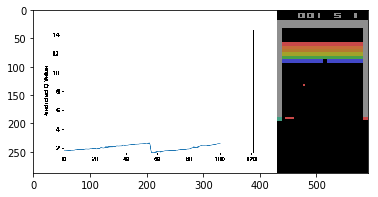

In [20]:
plt.imshow(obvs_qgraph[100])

In [21]:
generate_video(image_list=obvs_qgraph, folder='./qgraph_tmp', video_name='./videos/dqn_qgraph.mp4')